In [3]:
# Step 1: Data Cleaning – Missing Values

import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv("/home/karera/Desktop/SEMISTER11/big data/Churndata(1).csv")

# Convert 'TotalCharges' to numeric, coerce errors to NaN
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Check missing values across all columns
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

# Impute 'TotalCharges' for customers with tenure = 0 using MonthlyCharges * tenure
# This preserves the logic that TotalCharges = MonthlyCharges × tenure
df.loc[df["TotalCharges"].isnull(), "TotalCharges"] = (
    df.loc[df["TotalCharges"].isnull(), "MonthlyCharges"] *
    df.loc[df["TotalCharges"].isnull(), "tenure"]
)

# Verify no more missing values in TotalCharges
print("\nMissing values after imputation:\n", df.isnull().sum())

# Optional: If any other numeric columns had missing values, fill with median
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"Imputed missing values in {col} with median: {median_val}")


Missing values per column:
 customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Missing values after imputation:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
C

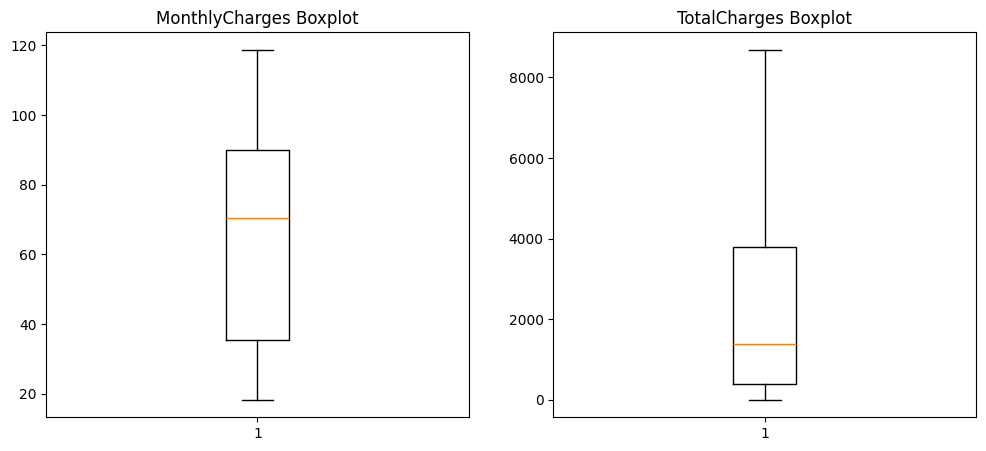

MonthlyCharges outliers count: 0
TotalCharges outliers count: 0
After capping:
       MonthlyCharges  TotalCharges
count     7043.000000   7043.000000
mean        64.761692   2279.734304
std         30.090047   2266.794470
min         18.250000      0.000000
25%         35.500000    398.550000
50%         70.350000   1394.550000
75%         89.850000   3786.600000
max        118.750000   8684.800000


In [5]:
# step 2: outlier  detection  and  treatmet
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Visualize outliers
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.boxplot(df['MonthlyCharges'])
plt.title('MonthlyCharges Boxplot')

plt.subplot(1, 2, 2)
plt.boxplot(df['TotalCharges'])
plt.title('TotalCharges Boxplot')

plt.show()

# Step 2: Detect outliers using IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

monthly_outliers = detect_outliers_iqr(df, 'MonthlyCharges')
total_outliers = detect_outliers_iqr(df, 'TotalCharges')

print("MonthlyCharges outliers count:", monthly_outliers.shape[0])
print("TotalCharges outliers count:", total_outliers.shape[0])

# Step 3: Cap outliers (Winsorization)
def cap_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[column] = data[column].clip(lower=lower_bound, upper=upper_bound)

cap_outliers_iqr(df, 'MonthlyCharges')
cap_outliers_iqr(df, 'TotalCharges')

# Step 4: Verify
print("After capping:")
print(df[['MonthlyCharges','TotalCharges']].describe())


In [7]:
# ---------------------------
# Data Transformation: Categorical Encoding + Tenure Grouping
# ---------------------------

# 1️⃣ Transform 'tenure' into interpretable bins
df["TenureGroup"] = pd.cut(
    df["tenure"],
    bins=[0, 12, 24, 48, 72],
    labels=["0-1yr", "1-2yr", "2-4yr", "4-6yr"]
)

# 2️⃣ Identify categorical and numerical features
categorical_features = [
    "gender", "Partner", "Dependents", "PhoneService", "MultipleLines",
    "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies", "Contract",
    "PaperlessBilling", "PaymentMethod", "TenureGroup"
]

numerical_features = ["SeniorCitizen", "tenure", "MonthlyCharges"]

# 3️⃣ Build preprocessing pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numerical_features),
    ("cat", categorical_transformer, categorical_features)
])

# 4️⃣ Apply transformations
X = df[numerical_features + categorical_features]
y = df["Churn"].map({"No": 0, "Yes": 1})

X_transformed = preprocessor.fit_transform(X)

print("Data Transformation completed!")
print("Transformed feature shape:", X_transformed.shape)


Data Transformation completed!
Transformed feature shape: (7043, 32)


In [8]:
# ---------------------------
# 1️⃣ External Internet Plan Dataset
# ---------------------------
internet_plans = pd.DataFrame({
    "InternetService": ["DSL", "Fiber optic", "Cable"],
    "Speed": [25, 100, 50],           # Mbps
    "DataAllowance": [500, 2000, 1000] # GB
})

# ---------------------------
# 2️⃣ Merge with Telco dataset
# ---------------------------
# Use a left join to keep all Telco customers
df = df.merge(internet_plans, on="InternetService", how="left")

# ---------------------------
# 3️⃣ Handle missing plan info
# ---------------------------
# For customers without a matching plan, fill Speed and DataAllowance with 0
df[["Speed", "DataAllowance"]] = df[["Speed", "DataAllowance"]].fillna(0)

# ---------------------------
# 4️⃣ Update numeric and categorical feature lists
# ---------------------------
# Add new numeric columns to numeric_features
numeric_features = ["SeniorCitizen", "tenure", "MonthlyCharges", "Speed", "DataAllowance", "TenureGroup"]

# Categorical features remain the same
categorical_features = [
    "gender", "Partner", "Dependents", "PhoneService", "MultipleLines",
    "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies", "Contract",
    "PaperlessBilling", "PaymentMethod", "TenureGroup"
]

# ---------------------------
# 5️⃣ Optional: check merged data
# ---------------------------
print(df[["InternetService", "Speed", "DataAllowance"]].head(10))
print("Numeric Features:", numeric_features)
print("Categorical Features:", categorical_features)


  InternetService  Speed  DataAllowance
0             DSL   25.0          500.0
1             DSL   25.0          500.0
2             DSL   25.0          500.0
3             DSL   25.0          500.0
4     Fiber optic  100.0         2000.0
5     Fiber optic  100.0         2000.0
6     Fiber optic  100.0         2000.0
7             DSL   25.0          500.0
8     Fiber optic  100.0         2000.0
9             DSL   25.0          500.0
Numeric Features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'Speed', 'DataAllowance', 'TenureGroup']
Categorical Features: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TenureGroup']


In [10]:
# ---------------------------
# Correct numeric and categorical features
# ---------------------------
numeric_features = ["SeniorCitizen", "tenure", "MonthlyCharges", "Speed", "DataAllowance"]
categorical_features = [
    "gender", "Partner", "Dependents", "PhoneService", "MultipleLines",
    "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies",
    "Contract", "PaperlessBilling", "PaymentMethod", "TenureGroup"
]

# ---------------------------
# ColumnTransformer
# ---------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

# ---------------------------
# Full Pipeline with SMOTE + Logistic Regression
# ---------------------------
model = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", LogisticRegression(max_iter=2000, solver="lbfgs"))
])

# ---------------------------
# Feature matrix and target
# ---------------------------
X = df[numeric_features + categorical_features]
y = df["Churn"].map({"No": 0, "Yes": 1})

# ---------------------------
# Train/test split
# ---------------------------
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ---------------------------
# Train the model
# ---------------------------
model.fit(X_train, y_train)
print("Pipeline with integrated internet plans trained successfully!")

# ---------------------------
# Check transformed feature shape
# ---------------------------
X_transformed = preprocessor.fit_transform(X)
print("Transformed feature shape:", X_transformed.shape)


Pipeline with integrated internet plans trained successfully!
Transformed feature shape: (7043, 34)


In [12]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split

# ---------------------------
# Define raw features and target
# ---------------------------
raw_features = [
    "gender", "SeniorCitizen", "Partner", "Dependents", "tenure",
    "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity",
    "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV",
    "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod",
    "MonthlyCharges", "TenureGroup"
]

X = df[raw_features].copy()
y = df["Churn"].map({"No": 0, "Yes": 1})

# ---------------------------
# Identify numeric and categorical features
# ---------------------------
numeric_features = ["SeniorCitizen", "tenure", "MonthlyCharges"]
categorical_features = [
    "gender", "Partner", "Dependents", "PhoneService", "MultipleLines",
    "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies", "Contract",
    "PaperlessBilling", "PaymentMethod", "TenureGroup"
]

# ---------------------------
# Build preprocessing pipelines
# ---------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

# ---------------------------
# Build full pipeline with VarianceThreshold (Data Reduction) + SMOTE + Logistic Regression
# ---------------------------
model = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("variance_threshold", VarianceThreshold(threshold=0.01)),  # Data Reduction
    ("smote", SMOTE(random_state=42)),
    ("classifier", LogisticRegression(max_iter=2000, solver="lbfgs"))
])

# ---------------------------
# Train/test split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ---------------------------
# Train the pipeline
# ---------------------------
model.fit(X_train, y_train)
print("Pipeline with Data Reduction trained successfully!")

# ---------------------------
# Check which features were kept after reduction
# ---------------------------
selected_features_mask = model.named_steps['variance_threshold'].get_support()
preprocessed_features = model.named_steps['preprocessor'].get_feature_names_out()
selected_features = preprocessed_features[selected_features_mask]

print("Number of features before reduction:", len(preprocessed_features))
print("Number of features after reduction:", len(selected_features))
print("Selected Features:", selected_features)


Pipeline with Data Reduction trained successfully!
Number of features before reduction: 32
Number of features after reduction: 32
Selected Features: ['num__SeniorCitizen' 'num__tenure' 'num__MonthlyCharges'
 'cat__gender_Male' 'cat__Partner_Yes' 'cat__Dependents_Yes'
 'cat__PhoneService_Yes' 'cat__MultipleLines_No phone service'
 'cat__MultipleLines_Yes' 'cat__InternetService_Fiber optic'
 'cat__InternetService_No' 'cat__OnlineSecurity_No internet service'
 'cat__OnlineSecurity_Yes' 'cat__OnlineBackup_No internet service'
 'cat__OnlineBackup_Yes' 'cat__DeviceProtection_No internet service'
 'cat__DeviceProtection_Yes' 'cat__TechSupport_No internet service'
 'cat__TechSupport_Yes' 'cat__StreamingTV_No internet service'
 'cat__StreamingTV_Yes' 'cat__StreamingMovies_No internet service'
 'cat__StreamingMovies_Yes' 'cat__Contract_One year'
 'cat__Contract_Two year' 'cat__PaperlessBilling_Yes'
 'cat__PaymentMethod_Credit card (automatic)'
 'cat__PaymentMethod_Electronic check' 'cat__Payment

In [15]:
# Count number of churned and non-churned customers
churn_counts = df['Churn'].value_counts()
print("Churn class distribution:")
print(churn_counts)

# Calculate percentage of each class
churn_percent = df['Churn'].value_counts(normalize=True) * 100
print("\nChurn class distribution (%):")
print(churn_percent)


Churn class distribution:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn class distribution (%):
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


In [20]:
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
import pandas as pd

# One-hot encode categorical columns
X_encoded = pd.get_dummies(X_train, drop_first=True)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_encoded, y_train)

# Check new distribution
from collections import Counter
print("Training set class distribution after SMOTE:")
print(Counter(y_train_resampled))


Training set class distribution after SMOTE:
Counter({0: 4139, 1: 4139})
